# Modelos Generativos

## DCGAN - Imagen

Creado por *Ricardo Kleinlein* para [Saturdays.AI](https://saturdays.ai/).

Disponible bajo una licencia [Creative Commons](https://creativecommons.org/licenses/by/4.0/).

---

## Sobre el uso de Jupyter Notebooks

Este notebook ha sido implementado en Python, pero para su ejecución no es
necesario conocer el lenguaje en profundidad. Solamente se debe ejecutar cada
una de las celdas, teniendo en cuenta que hay que ejecutar una celda a la vez
y secuencialmente, tal y como figuran en orden de aparición.

Para ejecutar cada celda pulse en el botón ▶ en la esquina superior izquierda
de cada celda. Mientras se esté ejecutando ese fragmento de código,
el botón estará girando. En caso de querer detener dicha ejecución, pulse
nuevamente sobre este botón mientras gira y la ejecución se detendrá. En caso
de que la celda tenga alguna salida (texto, gráficos, etc) será mostrada
justo después de esta y antes de mostrar la siguiente celda. El notebook
estará guiado con todas las explicaciones necesarias, además irá acompañado
por comentarios en el código para facilitar su lectura.

En caso de tener alguna duda, anótela. Dedicaremos un tiempo a plantear y
resolver la mayoría delas dudas que puedan aparecer.


## Objetivo del notebook

Implementar, entrenar y evaluar una Red Generativa Adversarial (GAN) que
genere números escritos "a mano".

## Importamos las librerías necesarias

In [1]:
import os
import glob
import imageio
import matplotlib.pyplot as plt
import PIL
import time
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import layers

## Preparar los datos de entrenamiento

Los datos vienen en forma de imágenes en blanco y negro, de pocos píxeles de
 tamaño (28 x 28). Vamos a seleccionar un subset de 5000 de las 60000
 imágenes originales disponibles y a prepararlas para poder introducirlas
 como entrada a una GAN.

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
BUFFER_SIZE = 500
BATCH_SIZE = 32
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

## DCGAN

De Deep Convolutional, la GAN que vamos a implementar es una arquitectura
muy conocida, y esquemáticamente se basa en redes convolucionales con la
siguiente arquitectura:

![DCGAN](./assets/dcgan.png)

No entraremos (al menos en principio, las dudas son bienvenidas) a detallar
la estructura de la red, sino que simplemente la entrenaremos y usaremos
para generar nuestras propias imágenes.

In [3]:
# Creamos el generador

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [4]:
# Creamos el discriminador

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

### Sin entrenar

¿Qué aspecto tendrá una imagen generada antes de entrenar?

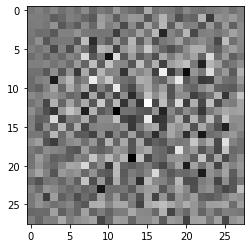

In [5]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### ¿Y qué opinará el discriminador?

¿Pasará por buena?

In [6]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.0002392]], shape=(1, 1), dtype=float32)


## Función de pérdidas

In [7]:
# Cross-Entropy Loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Función de pérdidas en particular para el discriminador

Se encarga de minimizar los errores cometidos por la clasificación al
predecir si una muestra es real o no.

In [8]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Función de pérdidas en particular para el generador

Se encarga de acercar lo máximo posible la semejanza entre las imágenes
creadas por la red y las originales, penalizando las diferencias.

In [9]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [10]:
# Elegimos un optimizador Adam (AVANZADO)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Creación de checkpoints

Como el modelo entrenará durante algunas iteraciones, nos interesa quedarnos
 únicamente con el modelo que mejor lo haga según nuestras funciones de
 pérdidas.

In [11]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Entrenamos!

In [15]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [12]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [13]:
def train(dataset, epochs):
  for epoch in tqdm(range(epochs), total=epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  generate_and_save_images(generator,
                           epochs,
                           seed)

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

Una vez hemos definido el bucle de entrenamiento (es posiblemente una de las
 partes más difíciles de entender para alguien no experto en el tema),
 podemos entrenar propiamente.

In [25]:
#train(train_dataset, EPOCHS)

  0%|          | 0/50 [03:00<?, ?it/s]


KeyboardInterrupt: 

In [14]:
# Recogemos el mejor modelo
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Visualización de resultados

Vamos a crear un gif que nos permita ver de un único vistazo cómo ha ido
evolucionando el proceso de aprendizaje de la GAN.

In [15]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


NameError: name 'filename' is not defined